In [4]:
from brian2 import *
import brian2.numpy_ as np
prefs.codegen.target = 'numpy'

start_scope()
# Implementing the independent CaL current.

duration = 100* ms
# Parameters
C = 1 * ufarad
gCaLmax = 0.001 * siemens
Cai = 50 * nmole
Cao = 2 * mmole
temp = 34
KTF = ((25 / 293.15) * (temp + 273.15))
f = KTF * mV / 2
kiCaL = 1 * nmole
h2CaL = kiCaL / (kiCaL + Cai)
q10CaL = 5
qtCaL = q10CaL ** ((temp - 25) / 10)
a0mCaL = 0.1
zetamCaL = 2/mV
vhalfmCaL = 4*mV
gmmCaL = 0.1
V0 = -65 * mV

@check_units(z=1, result=1)
def efun(z):
    if (np.absolute(z) < 0.0001):
        return 1 - z / 2
    else:
        return z / (exp(z) - 1)


@check_units(V=volt, result=1)
def nu(V):
    return V / f


@check_units(V=volt, result=volt)
def ghk(V):
    return -f * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))

eqs = Equations('''
                    dV/dt = (ICaL + I)/C : volt
                    #ICaL = gCaLmax*mCaL*mCaL*h2CaL*ghk(V) : amp (constant over dt)
                    ICaL = gCaL*ghk(V) : amp (constant over dt)
                    gCaL = gCaLmax*mCaL*mCaL*h2CaL : siemens
                    dmCaL/dt = (infmCaL - mCaL)/tauCaL : 1
                    infmCaL = alpCaL * 1/(alpCaL + betCaL) : 1
                    alpCaL = 15.69*(mV**-1)*(-V+81.5*mV)/(exp((-V+81.5*mV)/(10*mV))-1) : 1
                    betCaL = 0.29 * exp(-V/(10.86*mV)) : 1
                    tauCaL = betmtCaL*ms/(qtCaL*a0mCaL*(1+alpmtCaL)) : second 
                    alpmtCaL = exp(0.0378*zetamCaL*(V-vhalfmCaL)) : 1
                    betmtCaL = exp(0.0378*zetamCaL*gmmCaL*(V-vhalfmCaL)) : 1
                    I : amp                    
                    ''')


group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')
M = StateMonitor(group, variables=True, record=True)

#run(1*ms)

store()


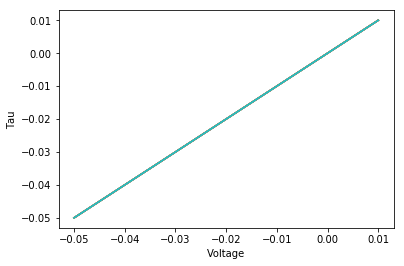

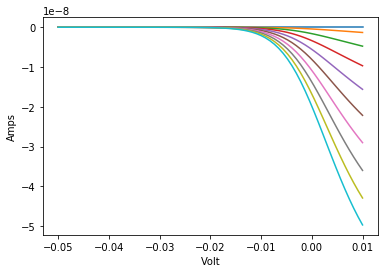

In [5]:
# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    group.V = volt
    
    alp0 = 15.69*(mV**-1)*(-V0+81.5*mV)/(exp((-V0+81.5*mV)/(10*mV))-1)
    bet0 = 0.29 * exp(-V0/(10.86*mV))
    group.mCaL = alp0 * 1/(alp0 + bet0)
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.ICaL[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()